Gen 0: best penalty=0.0000, best cost=19.50
Gen 10: best penalty=0.0000, best cost=3.40
Gen 20: best penalty=0.0000, best cost=1.90
Gen 30: best penalty=0.0000, best cost=1.60
Gen 40: best penalty=0.0000, best cost=1.60


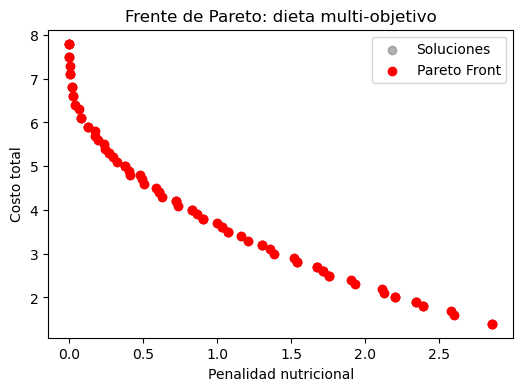

--- Solución 0 ---
Porciones: [ 4  0  0  2  6 10  1  0  0  0]
Penalidad: 0.0 Costo: 7.800000000000001
Totales: {'kcal': np.int32(2315), 'protein': np.int32(110), 'fat': np.int32(70), 'carbs': np.int32(323), 'calcium': np.int32(1020), 'iron': np.int32(20)}
--- Solución 1 ---
Porciones: [0 0 0 0 0 7 0 0 0 0]
Penalidad: 2.8550553853367764 Costo: 1.4000000000000001
Totales: {'kcal': np.int32(490), 'protein': np.int32(42), 'fat': np.int32(35), 'carbs': np.int32(7), 'calcium': np.int32(175), 'iron': np.int32(7)}
--- Solución 2 ---
Porciones: [ 4  1  0  2  5 10  0  0  0  0]
Penalidad: 0.0 Costo: 7.800000000000001
Totales: {'kcal': np.int32(2290), 'protein': np.int32(116), 'fat': np.int32(70), 'carbs': np.int32(310), 'calcium': np.int32(1040), 'iron': np.int32(22)}
--- Solución 3 ---
Porciones: [0 0 0 0 0 7 0 0 0 0]
Penalidad: 2.8550553853367764 Costo: 1.4000000000000001
Totales: {'kcal': np.int32(490), 'protein': np.int32(42), 'fat': np.int32(35), 'carbs': np.int32(7), 'calcium': np.int32(175

In [1]:
# ================================================
# Algoritmo genético multi-objetivo para dieta con costos
# Ejemplo estilo NSGA-II
# ================================================

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# -------------------- Datos de ejemplo --------------------
foods = pd.DataFrame([
    {"food":"Arroz",       "cost":0.5, "kcal":200, "protein":4, "fat":1, "carbs":44, "calcium":10, "iron":1},
    {"food":"Frijoles",    "cost":0.7, "kcal":150, "protein":9, "fat":1, "carbs":27, "calcium":50, "iron":3},
    {"food":"Pollo",       "cost":1.5, "kcal":250, "protein":27,"fat":14,"carbs":0,  "calcium":15, "iron":1},
    {"food":"Leche",       "cost":0.8, "kcal":120, "protein":8, "fat":5, "carbs":11, "calcium":300,"iron":0},
    {"food":"Pan",         "cost":0.3, "kcal":80,  "protein":3, "fat":1, "carbs":15, "calcium":20, "iron":1},
    {"food":"Huevo",       "cost":0.2, "kcal":70,  "protein":6, "fat":5, "carbs":1,  "calcium":25, "iron":1},
    {"food":"Manzana",     "cost":0.4, "kcal":95,  "protein":0, "fat":0, "carbs":25, "calcium":10, "iron":0},
    {"food":"Espinaca",    "cost":0.6, "kcal":40,  "protein":5, "fat":0, "carbs":7,  "calcium":150,"iron":4},
    {"food":"Pescado",     "cost":2.0, "kcal":220, "protein":22,"fat":12,"carbs":0,  "calcium":30, "iron":1},
    {"food":"Carne",       "cost":1.8, "kcal":300, "protein":26,"fat":20,"carbs":0,  "calcium":20, "iron":2}
])

# Requerimientos mínimos diarios (ejemplo)
requirements = {"kcal":2000, "protein":50, "fat":70, "carbs":310, "calcium":1000, "iron":18}

# -------------------- Funciones de evaluación --------------------
def nutrition_totals(ind):
    totals = {k:0 for k in requirements}
    for i,(idx,row) in enumerate(foods.iterrows()):
        for k in requirements:
            totals[k] += ind[i] * row[k]
    return totals

def nutrition_penalty(ind):
    totals = nutrition_totals(ind)
    penalty = 0.0
    for k,req in requirements.items():
        deficit = max(0, req - totals[k])
        penalty += (deficit/req)**2
    return penalty

def cost_for_ind(ind):
    return sum(ind[i]*foods.loc[i,"cost"] for i in range(len(foods)))

def evaluate(ind):
    return nutrition_penalty(ind), cost_for_ind(ind)

# -------------------- Operadores GA --------------------
def init_population(pop_size, n_vars, max_portions=10):
    return np.random.randint(0, max_portions+1, size=(pop_size,n_vars))

def crossover(p1,p2):
    mask = np.random.rand(len(p1))<0.5
    c1 = np.where(mask,p1,p2)
    c2 = np.where(mask,p2,p1)
    return c1,c2

def mutate(ind,prob=0.1,max_portions=10):
    for i in range(len(ind)):
        if random.random()<prob:
            ind[i] = np.clip(ind[i]+random.choice([-1,1]),0,max_portions)
    return ind

# -------------------- NSGA-II helpers --------------------
def dominates(a,b):
    return np.all(a<=b) and np.any(a<b)

def fast_non_dominated_sort(objs):
    S=[[] for _ in range(len(objs))]
    n=[0]*len(objs)
    rank=[0]*len(objs)
    fronts=[[]]
    for p in range(len(objs)):
        for q in range(len(objs)):
            if dominates(objs[p],objs[q]):
                S[p].append(q)
            elif dominates(objs[q],objs[p]):
                n[p]+=1
        if n[p]==0:
            rank[p]=0
            fronts[0].append(p)
    i=0
    while fronts[i]:
        Q=[]
        for p in fronts[i]:
            for q in S[p]:
                n[q]-=1
                if n[q]==0:
                    rank[q]=i+1
                    Q.append(q)
        i+=1
        fronts.append(Q)
    return fronts[:-1],rank

def crowding_distance(front,objs):
    l=len(front)
    if l==0: return []
    m=objs.shape[1]
    distance=np.zeros(l)
    for i in range(m):
        order=np.argsort(objs[front,i])
        distance[order[0]]=distance[order[-1]]=np.inf
        fmin=objs[front[order[0]],i]
        fmax=objs[front[order[-1]],i]
        if fmax>fmin:
            for j in range(1,l-1):
                distance[order[j]]+=(objs[front[order[j+1]],i]-objs[front[order[j-1]],i])/(fmax-fmin)
    return distance

# -------------------- NSGA-II principal --------------------
def nsga2(pop_size=60, gens=50, max_portions=10, verbose=True):
    n_vars=len(foods)
    pop=init_population(pop_size,n_vars,max_portions)
    objs=np.array([evaluate(ind) for ind in pop])

    for gen in range(gens):
        offspring=[]
        while len(offspring)<pop_size:
            i1,i2=random.sample(range(pop_size),2)
            p1,p2=pop[i1],pop[i2]
            c1,c2=crossover(p1,p2)
            offspring.append(mutate(c1.copy(),0.1,max_portions))
            if len(offspring)<pop_size:
                offspring.append(mutate(c2.copy(),0.1,max_portions))
        offspring=np.array(offspring)
        offspring_objs=np.array([evaluate(ind) for ind in offspring])
        combined=np.vstack([pop,offspring])
        combined_objs=np.vstack([objs,offspring_objs])
        fronts,rank=fast_non_dominated_sort(combined_objs)
        new_pop=[]
        new_objs=[]
        for front in fronts:
            if len(new_pop)+len(front)<=pop_size:
                new_pop.extend(combined[front])
                new_objs.extend(combined_objs[front])
            else:
                dist=crowding_distance(front,combined_objs)
                order=np.argsort(-dist)
                needed=pop_size-len(new_pop)
                chosen=[front[i] for i in order[:needed]]
                new_pop.extend(combined[chosen])
                new_objs.extend(combined_objs[chosen])
                break
        pop=np.array(new_pop)
        objs=np.array(new_objs)
        if verbose and gen%10==0:
            best_pen=np.min(objs[:,0])
            best_cost=np.min(objs[:,1])
            print(f"Gen {gen}: best penalty={best_pen:.4f}, best cost={best_cost:.2f}")
    fronts,rank=fast_non_dominated_sort(objs)
    pareto_front=fronts[0]
    return pop,objs,pareto_front

# -------------------- Ejecución demo --------------------
pop,objs,pareto_front=nsga2(pop_size=80,gens=50)

plt.figure(figsize=(6,4))
plt.scatter(objs[:,0],objs[:,1],c='gray',alpha=0.6,label="Soluciones")
plt.scatter(objs[pareto_front,0],objs[pareto_front,1],c='red',label="Pareto Front")
plt.xlabel("Penalidad nutricional")
plt.ylabel("Costo total")
plt.legend()
plt.title("Frente de Pareto: dieta multi-objetivo")
plt.show()

# Mostrar algunas soluciones no dominadas
for idx in pareto_front[:5]:
    print(f"--- Solución {idx} ---")
    print("Porciones:",pop[idx])
    print("Penalidad:",objs[idx,0],"Costo:",objs[idx,1])
    print("Totales:",nutrition_totals(pop[idx]))
